# A training example in Pytorch
## Introduction
### Task
In this notebook we will train a neural network to do a simple task. This will be a classification task : as explained in the first week of lectures, classification basically means to find a *decision boundary* over a space of real numbers. For representation purposes we will work with a 2D example : the decision boundary will be a cercle. More precisely, it will be the unit circle in the plan.
![](unitycircle.png)
### Sampling
We will generate points $(x_1,x_2)$ to classify, and their class $y$. The actual decision fonction is $y=1_{x_1^2+x_2^2<1}$.

To have a balanced dataset with about as many points in each class, we will sample uniformly over polar coordinates,  within the circle of center 0 and radius 2.

In [41]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import time
%matplotlib inline

In [42]:
def sample_points(n):
    # returns (X,Y), where X of shape (n,2) is the numpy array of points and Y is the (n) array of classes
    
    radius = np.random.uniform(low=0,high=2,size=n).reshape(-1,1) # uniform radius between 0 and 2
    angle = np.random.uniform(low=0,high=2*np.pi,size=n).reshape(-1,1) # uniform angle
    x1 = radius*np.cos(angle)
    x2=radius*np.sin(angle)
    y = (radius<1).astype(int).reshape(-1)
    x = np.concatenate([x1,x2],axis=1)
    return x,y

In [43]:
# Generate the data
trainx,trainy = sample_points(10000)
valx,valy = sample_points(500)
testx,testy = sample_points(500)

print(trainx.shape,trainy.shape)

(10000, 2) (10000,)


Our model will be a multi-layer perceptron with one hidden layer, and an output of size 2 since we have two classes. Since it is a binary classification task we could also use just one output and a zero threshold, but we will use two to illustrate the use of the pytorch Cross-Entropy loss (with one output, you would use BinaryCrossEntropy).

As you know from the lectures, such a model cannot represent a circular boundary but could represent a polygonal boundary, whose number of sides is the number of neurons on the hidden layer. For example, with 6 hidden neurons the model could compute a hexagonal boundary that approximate the unity circle, such as :
![](hexagon.png)

Of course the trained model won't compute an actual hexagone, due to the activation that isn't a threshold, and the liberty of the final layer's weights (it does not have to be an AND). We can actually expect *better* accuracy than what a hexagon could do.

In [44]:
def generate_single_hidden_MLP(n_hidden_neurons):
    return nn.Sequential(nn.Linear(2,n_hidden_neurons),nn.ReLU(),nn.Linear(n_hidden_neurons,2))
model1 = generate_single_hidden_MLP(6)

To train our model, we will need to feed it with tensors. Let's transform our generated numpy arrays :

In [45]:
trainx = torch.from_numpy(trainx).float()
valx = torch.from_numpy(valx).float()
testx = torch.from_numpy(testx).float()
trainy = torch.from_numpy(trainy)
valy = torch.from_numpy(valy)
testy = torch.from_numpy(testy)
print(trainx.type(),trainy.type())

torch.FloatTensor torch.LongTensor


Now we will define our training routine. There is the question of whether to perform our traing on CPU or GPU. The best thing to do is to use a flag variable that you will set, when you actually do the training.

In [46]:
def training_routine(net,dataset,n_iters,gpu):
    # organize the data
    train_data,train_labels,val_data,val_labels = dataset
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(net.parameters(),lr=0.01)
    
    # use the flag
    if gpu:
        train_data,train_labels = train_data.cuda(),train_labels.cuda()
        val_data,val_labels = val_data.cuda(),val_labels.cuda()
        net = net.cuda() # the network parameters also need to be on the gpu !
        print("Using GPU")
    else:
        print("Using CPU")
    for i in range(n_iters):
        # forward pass
        train_output = net(train_data)
        train_loss = criterion(train_output,train_labels)
        # backward pass and optimization
        train_loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        # Once every 100 iterations, print statistics
        if i%100==0:
            print("At iteration",i)
            # compute the accuracy of the prediction
            train_accuracy = (train_labels.eq(train_output.argmax(dim=1))).float().mean() 
            # Now for the validation set
            val_output = net(val_data)
            val_loss = criterion(val_output,val_labels)
            # compute the accuracy of the prediction
            val_accuracy = (val_labels.eq(val_output.argmax(dim=1))).float().mean() 
            print("Training loss :",train_loss.cpu().detach().numpy())
            print("Training accuracy :",train_accuracy.cpu().detach().numpy())
            print("Validation loss :",val_loss.cpu().detach().numpy())
            print("Validation accuracy :",val_accuracy.cpu().detach().numpy())
    
    net = net.cpu()

In [47]:
dataset = trainx,trainy,valx,valy

In [48]:
gpu = False
gpu = gpu and torch.cuda.is_available() # to know if you actually can use the GPU
begin = time.time()
training_routine(model1,dataset,10000,gpu)
end=time.time()

Using CPU
At iteration 0
Training loss : 0.7094736099243164
Training accuracy : 0.4997
Validation loss : 0.7025020122528076
Validation accuracy : 0.524
At iteration 100
Training loss : 0.6924378275871277
Training accuracy : 0.4692
Validation loss : 0.689512312412262
Validation accuracy : 0.488
At iteration 200
Training loss : 0.6808919310569763
Training accuracy : 0.4212
Validation loss : 0.6802194714546204
Validation accuracy : 0.438
At iteration 300
Training loss : 0.6705961227416992
Training accuracy : 0.4035
Validation loss : 0.6713734865188599
Validation accuracy : 0.416
At iteration 400
Training loss : 0.6606850028038025
Training accuracy : 0.4703
Validation loss : 0.6625954508781433
Validation accuracy : 0.462
At iteration 500
Training loss : 0.651013970375061
Training accuracy : 0.6005
Validation loss : 0.653831958770752
Validation accuracy : 0.6
At iteration 600
Training loss : 0.6415998935699463
Training accuracy : 0.6504
Validation loss : 0.6451891660690308
Validation accura

At iteration 5700
Training loss : 0.19849926233291626
Training accuracy : 0.9586
Validation loss : 0.1902962327003479
Validation accuracy : 0.958
At iteration 5800
Training loss : 0.1953829824924469
Training accuracy : 0.9582
Validation loss : 0.1873455047607422
Validation accuracy : 0.958
At iteration 5900
Training loss : 0.19244320690631866
Training accuracy : 0.9583
Validation loss : 0.1845509558916092
Validation accuracy : 0.96
At iteration 6000
Training loss : 0.18965516984462738
Training accuracy : 0.9579
Validation loss : 0.18190455436706543
Validation accuracy : 0.962
At iteration 6100
Training loss : 0.1870163381099701
Training accuracy : 0.9579
Validation loss : 0.1793961375951767
Validation accuracy : 0.962
At iteration 6200
Training loss : 0.1845097839832306
Training accuracy : 0.9574
Validation loss : 0.17701087892055511
Validation accuracy : 0.96
At iteration 6300
Training loss : 0.18212391436100006
Training accuracy : 0.9573
Validation loss : 0.17473553121089935
Validati

In [58]:
print("Training time :",end-begin)

Training time : 13.61394453048706


In [71]:
# Let's try with 3 hidden neurons.
model2 = generate_single_hidden_MLP(3) 
training_routine(model2,dataset,10000,gpu)

Using CPU
At iteration 0
Training loss : 0.7721424102783203
Training accuracy : 0.5003
Validation loss : 0.7745897173881531
Validation accuracy : 0.476
At iteration 100
Training loss : 0.7194032669067383
Training accuracy : 0.5177
Validation loss : 0.7196709513664246
Validation accuracy : 0.502
At iteration 200
Training loss : 0.6952459216117859
Training accuracy : 0.6279
Validation loss : 0.6937494874000549
Validation accuracy : 0.606
At iteration 300
Training loss : 0.6812130808830261
Training accuracy : 0.6313
Validation loss : 0.6784570217132568
Validation accuracy : 0.618
At iteration 400
Training loss : 0.6708069443702698
Training accuracy : 0.622
Validation loss : 0.6670488119125366
Validation accuracy : 0.642
At iteration 500
Training loss : 0.6614969372749329
Training accuracy : 0.62
Validation loss : 0.657058596611023
Validation accuracy : 0.634
At iteration 600
Training loss : 0.6524924039840698
Training accuracy : 0.6617
Validation loss : 0.647628128528595
Validation accura

At iteration 5700
Training loss : 0.27083608508110046
Training accuracy : 0.9122
Validation loss : 0.27582883834838867
Validation accuracy : 0.9
At iteration 5800
Training loss : 0.26541319489479065
Training accuracy : 0.9146
Validation loss : 0.26992836594581604
Validation accuracy : 0.906
At iteration 5900
Training loss : 0.2601531147956848
Training accuracy : 0.9188
Validation loss : 0.264261394739151
Validation accuracy : 0.91
At iteration 6000
Training loss : 0.2550504505634308
Training accuracy : 0.9231
Validation loss : 0.2588290274143219
Validation accuracy : 0.912
At iteration 6100
Training loss : 0.25010165572166443
Training accuracy : 0.9266
Validation loss : 0.2535479664802551
Validation accuracy : 0.916
At iteration 6200
Training loss : 0.24530282616615295
Training accuracy : 0.9299
Validation loss : 0.2485044151544571
Validation accuracy : 0.918
At iteration 6300
Training loss : 0.24065327644348145
Training accuracy : 0.9329
Validation loss : 0.24360352754592896
Validatio

In [60]:
out = model2(testx).argmax(dim=1).detach().numpy()
green = testx.numpy()[np.where(out==1)]
red = testx.numpy()[np.where(out==0)]
print(green.shape,red.shape)

(393, 2) (107, 2)


In [61]:
def print_model(model,datapoints):
    out = model(datapoints).argmax(dim=1).detach().numpy()
    green = datapoints.numpy()[np.where(out==1)]
    red = datapoints.numpy()[np.where(out==0)]

    circle1 = plt.Circle((0, 0), 1, color='y')
    circle2 = plt.Circle((0, 0), 1, color='b',fill=False)

    fig, ax = plt.subplots() # note we must use plt.subplots, not plt.subplot
    # (or if you have an existing figure)
    # fig = plt.gcf()
    # ax = fig.gca()
    plt.xlim((-2,2))
    plt.ylim((-2,2))

    pos_values = plt.scatter(x=green[:,0],y=green[:,1], color='g',)
    neg_values = plt.scatter(x=red[:,0],y=red[:,1], color='r',)

    ax.add_artist(circle1)
    ax.add_artist(circle2)
    ax.add_artist(pos_values)
    ax.add_artist(neg_values)

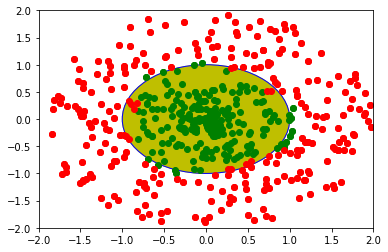

In [53]:
print_model(model1,testx)

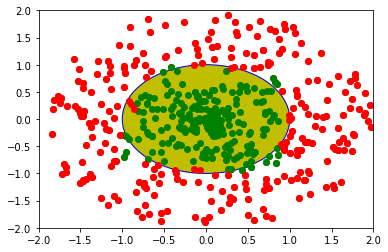

In [72]:
print_model(model2,testx)

In [69]:
model3 = generate_single_hidden_MLP(2) 
training_routine(model3,dataset,10000,gpu)

Using CPU
At iteration 0
Training loss : 0.7322251796722412
Training accuracy : 0.5003
Validation loss : 0.7439041137695312
Validation accuracy : 0.476
At iteration 100
Training loss : 0.692024827003479
Training accuracy : 0.5003
Validation loss : 0.6968146562576294
Validation accuracy : 0.476
At iteration 200
Training loss : 0.6811820268630981
Training accuracy : 0.6407
Validation loss : 0.6828126907348633
Validation accuracy : 0.64
At iteration 300
Training loss : 0.6767441630363464
Training accuracy : 0.6155
Validation loss : 0.6768767833709717
Validation accuracy : 0.612
At iteration 400
Training loss : 0.6735808849334717
Training accuracy : 0.5918
Validation loss : 0.6729535460472107
Validation accuracy : 0.576
At iteration 500
Training loss : 0.6706365346908569
Training accuracy : 0.5869
Validation loss : 0.6695631146430969
Validation accuracy : 0.566
At iteration 600
Training loss : 0.6676961779594421
Training accuracy : 0.5872
Validation loss : 0.6663118600845337
Validation acc

At iteration 5800
Training loss : 0.4886975586414337
Training accuracy : 0.7822
Validation loss : 0.4601275622844696
Validation accuracy : 0.8
At iteration 5900
Training loss : 0.4869404435157776
Training accuracy : 0.7818
Validation loss : 0.4580116868019104
Validation accuracy : 0.8
At iteration 6000
Training loss : 0.4852849245071411
Training accuracy : 0.7811
Validation loss : 0.4560043513774872
Validation accuracy : 0.8
At iteration 6100
Training loss : 0.48372387886047363
Training accuracy : 0.7807
Validation loss : 0.4541197419166565
Validation accuracy : 0.8
At iteration 6200
Training loss : 0.48225077986717224
Training accuracy : 0.7806
Validation loss : 0.45233890414237976
Validation accuracy : 0.794
At iteration 6300
Training loss : 0.480867475271225
Training accuracy : 0.7806
Validation loss : 0.45066410303115845
Validation accuracy : 0.794
At iteration 6400
Training loss : 0.4795684218406677
Training accuracy : 0.78
Validation loss : 0.44909292459487915
Validation accuracy

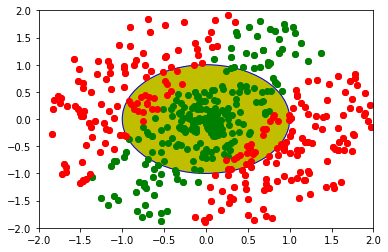

In [70]:
print_model(model3,testx)